In [2]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import optuna
import numpy as np  
import optuna.visualization as vis
import plotly

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 80.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [4]:

fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
        
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:,1]

    data=(data - np.mean(data)) / np.std(data)
    
    n_samples_resampled = int(len(data) * (fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)


    welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



# Datos Reales

 Tanto como los datos reales como lo simulados pueden ser normlaizados(por su maximo), los valores real estan en microvoltios, en la simulacion estan con 0.00070 microvoltios reposo 

In [5]:
def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    # Inicialización de arrays para promedios de bandas
    main_Delta = np.zeros(2)
    main_Theta = np.zeros(2)
    main_Alpha = np.zeros(2)
    main_Beta = np.zeros(2)
    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 



        data = np.loadtxt(nombre)*1e6
        data=(data - np.mean(data)) / np.std(data)
        Datos[i]=data


        frequencies, psd = signal.welch(data, fs, nperseg=nperseg, noverlap=noverlap)
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
        welch_datos[i]=welch_data

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        main_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        main_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        main_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        main_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'main_Delta': main_Delta,'main_Theta':main_Theta,"main_Alpha":main_Alpha,"main_Beta":main_Beta
    }


In [6]:
Params={'L': 57, 'P': 0.4965416953500361, 'Inh': 0.1840042178063965, 'Trest': -1.3321936159428258, 'Trelative': 1.8722523128821265, 'C_h': 9.984838343562668, 'Tipo_red': 0}

initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030, Params["Tipo_red"]]
generated_data = Simulado_EGG(initial_params)
reales_total = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])

['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


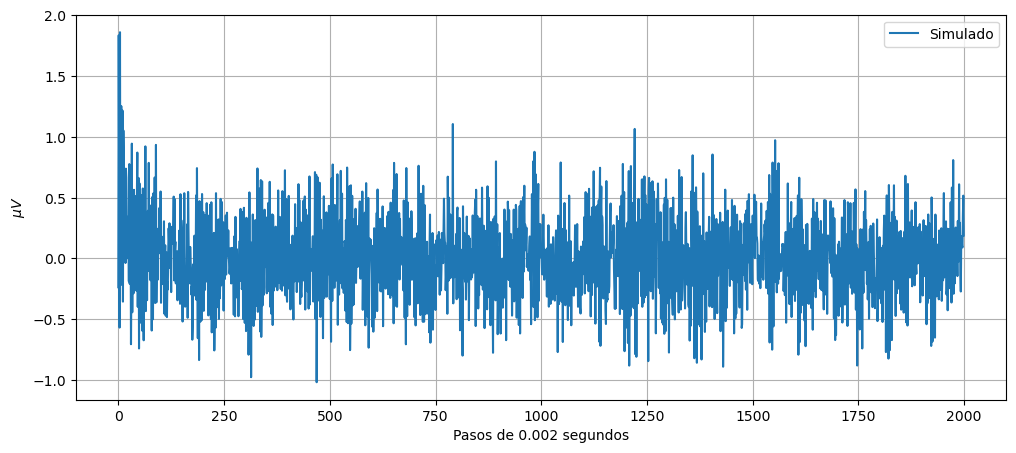

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
ax.plot(generated_data["data_resample"],label="Simulado")
# ax.plot(generated_data["butter"],label="Simulado con filtro butter")
# for i in range(3):
#     ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


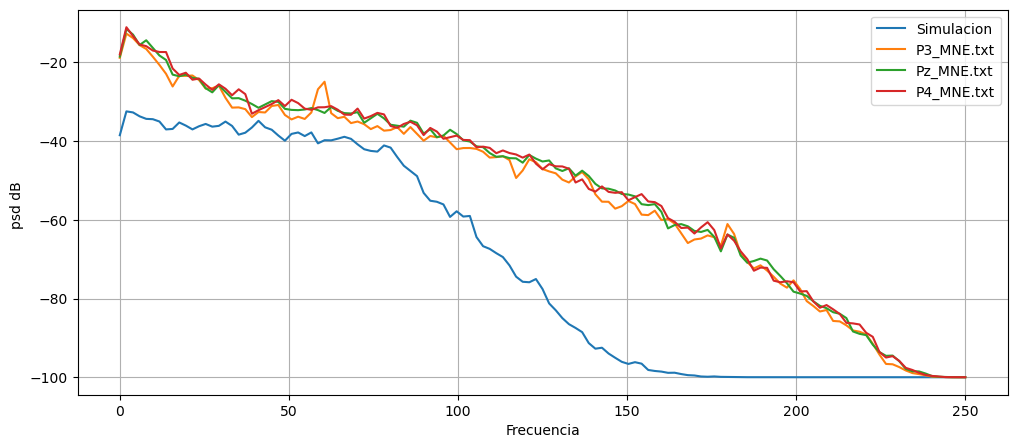

In [8]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i])

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [9]:

reales=reales_total["main_Delta"]+reales_total["main_Theta"]+reales_total["main_Alpha"]+reales_total["main_Beta"]

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',100,200)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -15.0, 15.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 10.0)
    params[6] = 8030
    params[7] = 0 #trial.suggest_int('Tipo_red',0,4)

    
    generated_data_total = Simulado_EGG(params)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        generated_data = generated_data_total["delta"] + generated_data_total["theta"] + generated_data_total["alpha"] + generated_data_total["beta"]
        difference = sum(abs(gd - rd) for gd, rd in zip(generated_data, reales))

        if trial.number > 30 and np.random.rand()<0.3:  
            params[7] = np.random.random_integers(0, 4) 
            params[2] += np.random.uniform(-0.01,0.01)  
            params[1] += np.random.uniform(-0.01,0.01)  
            #params[0] += np.random.random_integers(-5, 5) 


        trial.report(difference, step=trial.number)
        
        
        return difference
    else:
        return float('inf') 
    

# Create and optimize the study
study = optuna.create_study(study_name='4bandas_L100_Normal_z_score', storage='sqlite:///Estudios/4bandas_L100_Normal_z_score.db', load_if_exists=True)

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1)


[I 2024-09-30 14:12:37,224] Using an existing study with name '4bandas_L100_Normal_z_score' instead of creating a new one.
[I 2024-09-30 14:22:28,842] Trial 115 finished with value: 3.5058133549870965 and parameters: {'L': 177, 'P': 0.6374236171477293, 'Inh': 0.6094982787530797, 'Trest': -13.756085894303213, 'Trelative': -4.570817596646021, 'C_h': 2.4414269533885395}. Best is trial 57 with value: 3.1520608773850958.


In [10]:
print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:5]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


4bandas_L100_Normal_z_score

Trial 1:
Params: {'L': 174, 'P': 0.7820447414184227, 'Inh': 0.7427612768280734, 'Trest': -13.963821571763635, 'Trelative': -5.078184865796023, 'C_h': 2.8604463630954484}
Value: 3.1520608773850958

Trial 2:
Params: {'L': 177, 'P': 0.6374236171477293, 'Inh': 0.6094982787530797, 'Trest': -13.756085894303213, 'Trelative': -4.570817596646021, 'C_h': 2.4414269533885395}
Value: 3.5058133549870965

Trial 3:
Params: {'L': 183, 'P': 0.5669370941446865, 'Inh': 0.44416022926158205, 'Trest': -13.243772566920025, 'Trelative': -9.166752519518903, 'C_h': 3.277976217312237}
Value: 3.5747974105159406

Trial 4:
Params: {'L': 157, 'P': 0.7825317960328597, 'Inh': 0.8052268035082235, 'Trest': -11.96045068263393, 'Trelative': -6.68143127006847, 'C_h': 3.791999725707905}
Value: 3.6704995369364317

Trial 5:
Params: {'L': 175, 'P': 0.7131303505107922, 'Inh': 0.5398311116677496, 'Trest': -9.330620470416164, 'Trelative': -3.868440201138384, 'C_h': 1.3987326757306062}
Value: 4.00562491

In [12]:
vis.plot_param_importances(study)

[W 2024-09-28 20:21:56,519] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,519] Trial 16 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,520] Trial 50 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,520] Trial 58 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,521] Trial 188 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,521] Trial 244 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,521] Trial 286 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,522] Trial 350 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,522] Trial 403 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:21:56,5

In [13]:
vis.plot_parallel_coordinate(study)

[W 2024-09-28 20:22:21,745] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,746] Trial 16 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,746] Trial 50 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,746] Trial 58 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,747] Trial 188 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,747] Trial 244 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,747] Trial 286 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,748] Trial 350 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,748] Trial 403 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,7

In [14]:
optuna.visualization.plot_slice(study)

[W 2024-09-28 20:22:21,848] Trial 3 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,849] Trial 16 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,850] Trial 50 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,853] Trial 58 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,857] Trial 188 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,858] Trial 244 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,859] Trial 286 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,859] Trial 350 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,860] Trial 403 is omitted in visualization because its objective value is inf or nan.
[W 2024-09-28 20:22:21,8